# Análisis de ciencia de datos sobre propiedades termodinámicas del agua

# Librerías

Se importan las librerías necesarias para realizar análisis de datos:

- ## [numpy](https://numpy.org/) :
Es la base del “cómputo numérico” en Python: provee arreglos N-dimensionales (ndarray) y operaciones vectorizadas rápidas (álgebra lineal, FFT, números aleatorios, broadcasting).
Sirve para implementar modelos numéricos propios: balances de materia y energía discretizados, evaluación masiva de correlaciones (Cp, viscosidad, k, etc.), manipulación eficiente de señales o series temporales (sensores de planta), y prototipado de modelos de reactores o separaciones cuando se requiere rendimiento.
También es la estructura base sobre la que trabajan SciPy, pandas, scikit-learn, etc., así que dominar NumPy suele destrabar casi todo el ecosistema científico.

- ## [pandas](https://pandas.pydata.org/docs/index.html) :
Es una librería de manipulación y análisis de datos tabulares; su objeto central es el DataFrame (tabla con filas/columnas etiquetadas) con herramientas para limpiar, unir, agrupar, resumir y transformar datos.
Especialmente útil para datos experimentales y de planta: historiales de variables (temperaturas, caudales, presiones), campañas de laboratorio, resultados de cromatografía/espectroscopía, planes de muestreo, y datasets de simulación.
Aporta muchísimo en trazabilidad y preprocesamiento: manejo de faltantes, outliers, filtrado por rangos operativos, cálculo de variables derivadas (rendimiento, conversión, selectividad), y preparación consistente para regresión/ML, identificación de parámetros y reportes.

- ## [sympy](https://www.sympy.org/es/) :
Es una librería de matemáticas simbólicas (CAS: computer algebra system): manipula expresiones de forma exacta, hace derivadas/integrales simbólicas, simplifica, resuelve ecuaciones, trabaja con series y álgebra.
Ayuda cuando se necesita “forma analítica”: derivar ecuaciones de diseño (por ejemplo, expresiones cerradas de balances ideales), obtener jacobianos/gradientes exactos para optimización y estimación de parámetros, linealizar modelos para control, o verificar dimensionalidad/consistencia algebraica.
También sirve para generar automáticamente código numérico a partir de expresiones simbólicas (reduciendo errores en la transcripción de fórmulas).

- ## [scipy](https://scipy.org/es/) :
Es un conjunto de algoritmos “de ingeniería y ciencia” construido sobre NumPy: optimización, integración, interpolación, resolución de ecuaciones, ecuaciones diferenciales, estadística, álgebra lineal avanzada, señales, etc.
Suele ser la pieza principal para modelado y calibración: resolver ODE/PDE discretizadas (cinética de reacción, modelos dinámicos), ajuste no lineal de parámetros (rate laws, isoterma, transferencia de masa/calor), optimización de operación (setpoints, minimización de energía), e inferencia estadística (intervalos de confianza, pruebas).
Si el trabajo implica simulación dinámica, identificación de parámetros o reconciliación de datos de planta, SciPy suele aportar la “caja de herramientas” crítica.

- ## [matplotlib](https://matplotlib.org/) :
Es una librería completa para visualización (gráficas estáticas, animadas e interactivas) con control fino sobre ejes, estilos, anotaciones y exportación para reportes y publicaciones.
Es clave para análisis técnico: curvas de calibración, perfiles de concentración/temperatura, comparaciones modelo vs. experimento, diagramas de parity plot, residuales, tendencias temporales, y figuras “publicación-calidad”.
Se usa mucho cuando se necesita reproducibilidad y control exacto del gráfico (papers, tesis, informes industriales).

- ## [seaborn](https://seaborn.pydata.org/) :
Es una librería de visualización estadística basada en Matplotlib, con una interfaz de alto nivel para gráficos informativos (distribuciones, regresiones, matrices de correlación, categóricos) e integración cercana con pandas.
Ayuda especialmente en análisis exploratorio y estadístico: detectar relaciones entre variables de proceso, inspeccionar distribuciones (normalidad, colas), comparar campañas, visualizar sensibilidad, y entender datos multivariados antes de modelar.
Aporta velocidad para producir gráficos “estadísticos correctos” sin escribir tanto código de formato.

- ## [plotly](https://plotly.com/) : 
Es una librería de gráficos interactivos (zoom, hover, filtros) con calidad de publicación y soporte fuerte para web (dashboards).
Es muy útil para monitoreo y análisis interactivo: explorar ventanas de operación, comparar lotes, analizar datos de planta con interacción, y construir tableros para KPIs (indicadores clave de desempeño) como conversión, consumo energético, calidad, OEE, etc.
Cuando se requiere que otras personas “naveguen” los datos (sin programar) y se quiere interactividad, Plotly suele ser la opción más práctica.

In [65]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler

# Funciones

Definimos funciones que podriamos usar para convertir algunas columnas de los conjuntos de datos

In [66]:
def celsius_to_kelvin(T : float) -> float :
    return T + 273.15

# Importación de datos

Se importan los datos tal cual estan indicadas en el libro de Cengel :

- Las tablas de saturación de agua para Presiones definidas.
- Las tablas de saturación de agua para Temperautras definidas.
- Las tablas de vapor de agua sobrecalentado.
- Las tablas de agua en estado liquidosubenfriado.

In [67]:
P_saturado_csv_path = "datos/original/dataP_H2Osaturado_cengel.csv"
T_saturado_csv_path = "datos/original/dataT_H2Osaturado_cengel.csv"
vapsobrecalentado_csv_path = "datos/original/data_H2Ovapsobrecalentado_cengel.csv"
liqsubenfriado_csv_path = "datos/original/data_H2Oliqsubenfriado_cengel.csv"
solidvap_csv_path = "datos/original/dataT_H2Osaturadosolidvap_cengel.csv"

df_Psat = pd.read_csv(P_saturado_csv_path)
df_Tsat = pd.read_csv(T_saturado_csv_path)
df_vapsobrecalentado = pd.read_csv(vapsobrecalentado_csv_path)
df_liqsubenfriado = pd.read_csv(liqsubenfriado_csv_path)
df_solidvap = pd.read_csv(solidvap_csv_path)
display(df_Psat.head())

,P_kPa,T_C,v_f_m3/kg,v_g_m3/kg,u_f_kJ/kg,ufg_kJ_kg,u_g_kJ/kg,h_f_kJ/kg,hfg_kJ_kg,h_g_kJ/kg,s_f_kJ/kg.K,sfg_kJ_kgK,s_g_kJ/kg.K
0,1.0,6.97,0.001000,129.190,29.302,2355.2,2384.5,29.303,2484.4,2513.7,0.1059,8.8690,8.9749
1,1.5,13.02,0.001001,87.964,54.686,2338.1,2392.8,54.688,2470.1,2524.7,0.1956,8.6314,8.8270
2,2.0,17.50,0.001001,66.990,73.431,2325.5,2398.9,73.433,2459.5,2532.9,0.2606,8.4621,8.7227
3,2.5,21.08,0.001002,54.242,88.422,2315.4,2403.8,88.424,2451.0,2539.4,0.3118,8.3302,8.6421
4,3.0,24.08,0.001003,45.654,100.982,2306.9,2407.9,100.982,2443.9,2544.8,0.3543,8.2222,8.5765


# Análisis exploratorio
En esta etapa, se desean análisis que respondan preguntas sobre el estado de los datos, como llegan, que errores pueden existir en tipado, si estan o no estandarizados, etc...
Evitamos al máximo realizar gráficas o transformación y operaciones con los datos, solo queremos verificar coherencia de datos 

## Preguntas generales : 

|                                                            | Psat.                                                     | Tsat.                                                     | Vap sobre.                                                | Líq sobre.                                                |
| ---------------------------------------------------------- | --------------------------------------------------------- | --------------------------------------------------------- | --------------------------------------------------------- | --------------------------------------------------------- |
| ¿Que tipos de datos tiene en cada columna?                 | Todas son float                                           | Todas son float                                           | Todas son float                                           | Todas son float                                           |
| ¿Cuantos registros existen?                                | 73                                                        | 76                                                        | 531                                                       | 111                                                       |
| ¿Cuantas filas y columnas tiene cada dataframe?            | 13                                                        | 13                                                        | 6                                                         | 6                                                         |
| ¿Cuales son los valores de tendencia central de los datos? | observar .describe                                        | observar .describe                                        | observar .describe                                        | observar .describe                                        |
| ¿Cuales son los valores de dispersión de los datos?        |                                                           |                                                           |                                                           |                                                           |
| ¿En que estado estan los datos?                            | Sin valores nules, sin iconsistencias, totalmente limpios | Sin valores nules, sin iconsistencias, totalmente limpios | Sin valores nules, sin iconsistencias, totalmente limpios | Sin valores nules, sin iconsistencias, totalmente limpios |
| ¿Hay datos duplicados?                                     | no                                                        | no                                                        | no                                                        | no                                                        |

In [68]:
print(f"======   ANALISIS PARA ESTADO DE SATURACIÓN   ======\n")
print(f"\n* Primeras 10 filas para PRESION")
display(df_Psat.head(10))
print(f"\n* Información general y estado de los datos para PRESION\n")
df_Psat.info()
print(f"\n* Medidas estadísticas generales para PRESION")
display(df_Psat.describe())
print(f"\n* Para las tablas de saturación para PRESION: filas ({df_Psat.shape[0]}) ; columnas ({df_Psat.shape[1]})")

print(f"\n* Primeras 10 filas para TEMPERATURA")
display(df_Tsat.head(10))
print(f"\n* Información general y estado de los datos para TEMPERATURA\n")
df_Tsat.info()
print(f"\n* Medidas estadísticas generales para TEMPERATURA")
display(df_Tsat.describe())
print(f"\n* Para las tablas de saturación para TEMPERATURA: filas ({df_Tsat.shape[0]}) ; columnas ({df_Tsat.shape[1]})\n")

print(f"======   ANALISIS PARA ESTADO SOBRECALENTADO   ======\n")
print(f"\n* Primeras 10 filas")
display(df_vapsobrecalentado.head(10))
print(f"\n* Información general y estado de los datos para PRESION\n")
df_vapsobrecalentado.info()
print(f"\n* Medidas estadísticas generales para PRESION")
display(df_vapsobrecalentado.describe())
print(f"\n* Para las tablas de saturación para PRESION: filas ({df_vapsobrecalentado.shape[0]}) ; columnas ({df_vapsobrecalentado.shape[1]})\n")

print(f"======   ANALISIS PARA ESTADO SUBENFRIADO   ======\n")
print(f"\n* Primeras 10 filas")
display(df_liqsubenfriado.head(10))
print(f"\n* Información general y estado de los datos para PRESION\n")
df_liqsubenfriado.info()
print(f"\n* Medidas estadísticas generales para PRESION")
display(df_liqsubenfriado.describe())
print(f"\n* Para las tablas de saturación para PRESION: filas ({df_liqsubenfriado.shape[0]}) ; columnas ({df_liqsubenfriado.shape[1]})")

#display(df_Tsat.info())
#display(df_Tsat.describe())

======   ANALISIS PARA ESTADO DE SATURACIÓN   ======


* Primeras 10 filas para PRESION


,P_kPa,T_C,v_f_m3/kg,v_g_m3/kg,u_f_kJ/kg,ufg_kJ_kg,u_g_kJ/kg,h_f_kJ/kg,hfg_kJ_kg,h_g_kJ/kg,s_f_kJ/kg.K,sfg_kJ_kgK,s_g_kJ/kg.K
0,1.0,6.97,0.001000,129.190,29.302,2355.2,2384.5,29.303,2484.4,2513.7,0.1059,8.8690,8.9749
1,1.5,13.02,0.001001,87.964,54.686,2338.1,2392.8,54.688,2470.1,2524.7,0.1956,8.6314,8.8270
2,2.0,17.50,0.001001,66.990,73.431,2325.5,2398.9,73.433,2459.5,2532.9,0.2606,8.4621,8.7227
3,2.5,21.08,0.001002,54.242,88.422,2315.4,2403.8,88.424,2451.0,2539.4,0.3118,8.3302,8.6421
4,3.0,24.08,0.001003,45.654,100.982,2306.9,2407.9,100.982,2443.9,2544.8,0.3543,8.2222,8.5765
5,4.0,28.96,0.001004,34.791,121.390,2293.1,2414.5,121.390,2432.3,2553.7,0.4224,8.0510,8.4734
6,5.0,32.87,0.001005,28.185,137.750,2282.1,2419.8,137.750,2423.0,2560.7,0.4762,7.9176,8.3938
7,7.5,40.29,0.001008,19.233,168.740,2261.1,2429.8,168.750,2405.3,2574.0,0.5763,7.6738,8.2501
8,10.0,45.81,0.001010,14.670,191.790,2245.4,2437.2,191.810,2392.1,2583.9,0.6492,7.4996,8.1488
9,15.0,53.97,0.001014,10.020,225.930,2222.1,2448.0,225.940,2372.3,2598.3,0.7549,7.2522,8.0071



* Información general y estado de los datos para PRESION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P_kPa        73 non-null     float64
 1   T_C          73 non-null     float64
 2   v_f_m3/kg    73 non-null     float64
 3   v_g_m3/kg    73 non-null     float64
 4   u_f_kJ/kg    73 non-null     float64
 5   ufg_kJ_kg    73 non-null     float64
 6   u_g_kJ/kg    73 non-null     float64
 7   h_f_kJ/kg    73 non-null     float64
 8   hfg_kJ_kg    73 non-null     float64
 9   h_g_kJ/kg    73 non-null     float64
 10  s_f_kJ/kg.K  73 non-null     float64
 11  sfg_kJ_kgK   73 non-null     float64
 12  s_g_kJ/kg.K  73 non-null     float64
dtypes: float64(13)
memory usage: 7.5 KB

* Medidas estadísticas generales para PRESION


,P_kPa,T_C,v_f_m3/kg,v_g_m3/kg,u_f_kJ/kg,ufg_kJ_kg,u_g_kJ/kg,h_f_kJ/kg,hfg_kJ_kg,h_g_kJ/kg,s_f_kJ/kg.K,sfg_kJ_kgK,s_g_kJ/kg.K
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,4149.408562,181.834110,0.001259,7.356441,809.402781,1691.272603,2500.665753,816.950548,1853.513699,2670.458904,2.111525,4.578277,6.689793
std,6526.361644,106.912473,0.000386,21.360711,521.596822,562.394908,110.703459,533.765580,586.851461,139.090956,1.119445,2.192876,1.076705
min,1.000000,6.970000,0.001000,0.003106,29.302000,0.000000,2015.700000,29.303000,0.000000,2084.300000,0.105900,0.000000,4.407000
25%,125.000000,105.970000,0.001048,0.039448,444.230000,1448.900000,2455.700000,444.360000,1639.700000,2608.900000,1.374100,3.053000,5.973700
50%,750.000000,167.750000,0.001111,0.255520,708.400000,1865.600000,2536.800000,709.240000,2056.400000,2716.500000,2.019500,4.664200,6.683700
75%,5000.000000,263.940000,0.001286,1.375000,1148.100000,2068.800000,2577.900000,1154.500000,2240.600000,2770.800000,2.920700,5.910000,7.284100
max,22064.000000,373.950000,0.003106,129.190000,2015.700000,2355.200000,2603.200000,2084.300000,2484.400000,2803.200000,4.407000,8.869000,8.974900



* Para las tablas de saturación para PRESION: filas (73) ; columnas (13)

* Primeras 10 filas para TEMPERATURA


,T_C,P_kPa,v_f_m3/kg,v_g_m3/kg,u_f_kJ/kg,ufg_kJ_kg,u_g_kJ/kg,h_f_kJ/kg,hfg_kJ_kg,h_g_kJ/kg,s_f_kJ/kg.K,sfg_kJ_kgK,s_g_kJ/kg.K
0,0.01,0.6117,0.001000,206.000,0.000,2374.9,2374.9,0.001,2500.9,2500.9,0.0000,9.1556,9.1556
1,5.00,0.8725,0.001000,147.030,21.019,2360.8,2381.8,21.020,2489.1,2510.1,0.0763,8.9487,9.0249
2,10.00,1.2281,0.001000,106.320,42.020,2346.6,2388.7,42.022,2477.2,2519.2,0.1511,8.7488,8.8999
3,15.00,1.7057,0.001001,77.885,62.980,2332.5,2395.5,62.982,2465.4,2528.3,0.2245,8.5559,8.7803
4,20.00,2.3392,0.001002,57.762,83.913,2318.4,2402.3,83.915,2453.5,2537.4,0.2965,8.3696,8.6661
5,25.00,3.1698,0.001003,43.340,104.830,2304.3,2409.1,104.830,2441.7,2546.5,0.3672,8.1895,8.5567
6,30.00,4.2469,0.001004,32.879,125.730,2290.2,2415.9,125.740,2429.8,2555.6,0.4368,8.0152,8.4520
7,35.00,5.6291,0.001006,25.205,146.630,2276.0,2422.7,146.640,2417.9,2564.6,0.5051,7.8466,8.3517
8,40.00,7.3851,0.001008,19.515,167.530,2261.9,2429.4,167.530,2406.0,2573.5,0.5724,7.6832,8.2556
9,45.00,9.5953,0.001010,15.251,188.430,2247.7,2436.1,188.440,2394.0,2582.4,0.6386,7.5247,8.1633



* Información general y estado de los datos para TEMPERATURA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T_C          76 non-null     float64
 1   P_kPa        76 non-null     float64
 2   v_f_m3/kg    76 non-null     float64
 3   v_g_m3/kg    76 non-null     float64
 4   u_f_kJ/kg    76 non-null     float64
 5   ufg_kJ_kg    76 non-null     float64
 6   u_g_kJ/kg    76 non-null     float64
 7   h_f_kJ/kg    76 non-null     float64
 8   hfg_kJ_kg    76 non-null     float64
 9   h_g_kJ/kg    76 non-null     float64
 10  s_f_kJ/kg.K  76 non-null     float64
 11  sfg_kJ_kgK   76 non-null     float64
 12  s_g_kJ/kg.K  76 non-null     float64
dtypes: float64(13)
memory usage: 7.8 KB

* Medidas estadísticas generales para TEMPERATURA


,T_C,P_kPa,v_f_m3/kg,v_g_m3/kg,u_f_kJ/kg,ufg_kJ_kg,u_g_kJ/kg,h_f_kJ/kg,hfg_kJ_kg,h_g_kJ/kg,s_f_kJ/kg.K,sfg_kJ_kgK,s_g_kJ/kg.K
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,187.486316,4326.888729,0.001253,10.518691,831.385947,1676.427632,2507.813158,838.669474,1840.271053,2678.932895,2.151417,4.526922,6.678341
std,110.391943,6011.731499,0.000337,32.858285,524.015942,536.773788,100.479942,534.224236,552.119843,127.436601,1.152743,2.265203,1.115942
min,0.010000,0.611700,0.001000,0.003106,0.000000,0.000000,2015.700000,0.001000,0.000000,2084.300000,0.000000,0.000000,4.407000
25%,93.750000,81.002500,0.001039,0.029554,392.742500,1350.675000,2454.250000,392.827500,1535.075000,2606.625000,1.236025,2.769000,5.848675
50%,187.500000,1189.350000,0.001138,0.165130,794.955000,1792.550000,2535.750000,796.310000,1987.050000,2714.050000,2.211500,4.313850,6.525300
75%,281.250000,6541.100000,0.001337,2.075425,1234.575000,2105.750000,2586.100000,1243.300000,2272.825000,2780.275000,3.079675,6.194850,7.430875
max,373.950000,22064.000000,0.003106,206.000000,2015.700000,2374.900000,2603.200000,2084.300000,2500.900000,2803.200000,4.407000,9.155600,9.155600



* Para las tablas de saturación para TEMPERATURA: filas (76) ; columnas (13)

======   ANALISIS PARA ESTADO SOBRECALENTADO   ======


* Primeras 10 filas


,P_MPa,T_C,v_m3/kg,u_kJ/kg,h_kJ/kg,s_kJ/kg.K
0,0.01,45.81,14.670,2437.2,2583.9,8.1488
1,0.01,50.00,14.867,2443.3,2592.0,8.1741
2,0.01,100.00,17.196,2515.5,2687.5,8.4489
3,0.01,150.00,19.513,2587.9,2783.0,8.6893
4,0.01,200.00,21.826,2661.4,2879.6,8.9049
5,0.01,250.00,24.136,2736.1,2977.5,9.1015
6,0.01,300.00,26.446,2812.3,3076.7,9.2827
7,0.01,400.00,31.063,2969.3,3280.0,9.6094
8,0.01,500.00,35.680,3132.9,3489.7,9.8998
9,0.01,600.00,40.296,3303.3,3706.3,10.1631



* Información general y estado de los datos para PRESION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   P_MPa      531 non-null    float64
 1   T_C        531 non-null    float64
 2   v_m3/kg    531 non-null    float64
 3   u_kJ/kg    531 non-null    float64
 4   h_kJ/kg    531 non-null    float64
 5   s_kJ/kg.K  531 non-null    float64
dtypes: float64(6)
memory usage: 25.0 KB

* Medidas estadísticas generales para PRESION


,P_MPa,T_C,v_m3/kg,u_kJ/kg,h_kJ/kg,s_kJ/kg.K
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000
mean,10.610301,675.135876,1.867268,3376.833333,3789.338795,7.495237
std,14.994079,347.380429,7.694610,719.712086,901.060605,1.364587
min,0.010000,45.810000,0.001503,1609.700000,1699.900000,3.714900
25%,0.800000,400.000000,0.028820,2795.600000,3054.250000,6.604150
50%,4.000000,600.000000,0.109160,3281.400000,3675.300000,7.433700
75%,13.750000,1000.000000,0.487430,4007.500000,4588.350000,8.389950
max,60.000000,1300.000000,72.604000,4687.400000,5413.400000,11.585700



* Para las tablas de saturación para PRESION: filas (531) ; columnas (6)

======   ANALISIS PARA ESTADO SUBENFRIADO   ======


* Primeras 10 filas


,P_MPa,T_C,v_m3kg,u_kJkg,h_kJkg,s_kJkgK
0,5,0.0,0.000998,0.04,5.03,0.0001
1,5,20.0,0.001000,83.61,88.61,0.2954
2,5,40.0,0.001006,166.92,171.95,0.5705
3,5,60.0,0.001015,250.29,255.36,0.8287
4,5,80.0,0.001027,333.82,338.96,1.0723
5,5,100.0,0.001041,417.65,422.85,1.3034
6,5,120.0,0.001058,501.91,507.19,1.5236
7,5,140.0,0.001077,586.80,592.18,1.7344
8,5,160.0,0.001099,672.55,678.04,1.9374
9,5,180.0,0.001124,759.47,765.09,2.1338



* Información general y estado de los datos para PRESION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   P_MPa    111 non-null    int64  
 1   T_C      111 non-null    float64
 2   v_m3kg   111 non-null    float64
 3   u_kJkg   111 non-null    float64
 4   h_kJkg   111 non-null    float64
 5   s_kJkgK  111 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 5.3 KB

* Medidas estadísticas generales para PRESION


,P_MPa,T_C,v_m3kg,u_kJkg,h_kJkg,s_kJkgK
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,22.792793,176.422072,0.001176,757.714865,784.651171,1.994235
std,14.980058,109.527285,0.000208,491.058375,497.741102,1.117195
min,5.000000,0.000000,0.000977,0.040000,5.030000,-0.001000
25%,10.000000,80.000000,0.001021,332.140000,354.880000,1.067500
50%,20.000000,180.000000,0.001105,745.400000,767.680000,2.102000
75%,30.000000,260.000000,0.001261,1125.050000,1136.650000,2.877550
max,50.000000,380.000000,0.002038,1785.800000,1838.200000,4.014600



* Para las tablas de saturación para PRESION: filas (111) ; columnas (6)


# Operaciones de transformación
Realizamos estandarización de las tablas de datos como limpieza, normalización, operaciones, todo aquello que requiera en modificar columnas

## Operaciones :

### Para saturación : 
01. Mapeo de los nombres de columnas de tablas de saturación.
02. Eliminamos las columnas "gf", ya que estas columnas son el resultado de la diferencia entre el estado g y f, para las propiedades de energía interna, entalpía y entropía.
03. Para la tabla de saturación para temperaturas definidas, la cambiaremos de posición con la columna de presión
04. Unificamos ambas tablas
05. Ordenamos de menor a mayor por valor de presiones
06. Eliminamos registros duplicados
07. Cambiamos unidades C por K en la columna de temperatura

### Para estado sobrecalentado :
01. Mapeo de los nombres de columnas de tablas de saturación.
02. Eliminamos registros duplicados.
03. Cambiamos unidades MPa por kPa en la columna de presión.
04. Cambiamos unidades C por K en la columna de temperatura.

#### Para ambos conjuntos de datos, los guardamos para desarrollar en un proyecto posterior, un modelo de machine learning.

In [69]:
#   PARA TABLAS DE SATURACIÓN
df_Psat_cleaned = df_Psat.copy()
df_Tsat_cleaned = df_Tsat.copy()

#   01
name_col_map_sat = {
    "P_kPa" : "Presión [=] kPa",
    "T_C" : "Temperatura [=] C",
    "v_f_m3/kg" : "Volumen específico f [=] m³/kg",
    "v_g_m3/kg" : "Volumen específico g [=] m³/kg",
    "u_f_kJ/kg" : "Energía interna específica f [=] kJ/kg",
    "u_g_kJ/kg" : "Energía interna específica g [=] kJ/kg",
    "h_f_kJ/kg" : "Entalpía específica f [=] kJ/kg",
    "h_g_kJ/kg" : "Entalpía específica g [=] kJ/kg",
    "s_f_kJ/kg.K" : "Entropía específica f [=] kJ/kg.K",
    "s_g_kJ/kg.K" : "Entropía específica g [=] kJ/kg.K"
}

#   02
df_Psat_cleaned.drop(["ufg_kJ_kg","hfg_kJ_kg","sfg_kJ_kgK"], axis = 1, inplace=True) 
df_Tsat_cleaned.drop(["ufg_kJ_kg","hfg_kJ_kg","sfg_kJ_kgK"], axis = 1, inplace=True)

#   03
colP = df_Tsat_cleaned.pop("P_kPa")
df_Tsat_cleaned.insert(0, "P_kPa", colP)
colT = df_Tsat_cleaned.pop("T_C")
df_Tsat_cleaned.insert(1, "T_C", colT)

#   04
df_H2O_saturado = pd.concat([df_Psat_cleaned, df_Tsat_cleaned])

#   05
df_H2O_saturado = df_H2O_saturado.sort_values(by=["P_kPa"])

#   06
df_H2O_saturado = df_H2O_saturado.drop_duplicates(ignore_index=True)

#   07
df_H2O_saturado["T_C"] = df_H2O_saturado["T_C"].apply(celsius_to_kelvin)
df_H2O_saturado = df_H2O_saturado.rename(columns={"T_C": "T_K"})

In [70]:
#   PARA TABLAS DE VAPOR SOBRECALENTADO
df_vapsobrecalentado_cleaned = df_vapsobrecalentado.copy()

#   01
name_col_map_sat = {
    "P_kPa" : "Presión [=] kPa",
    "T_K" : "Temperatura [=] K",
    "v_m3/kg" : "Volumen específico [=] m³/kg",
    "u_kJ/kg" : "Energía interna específica f [=] kJ/kg",
    "h_kJ/kg" : "Entalpía específica f [=] kJ/kg",
    "s_kJ/kg.K" : "Entropía específica f [=] kJ/kg.K",
}

#   02
df_vapsobrecalentado_cleaned = df_vapsobrecalentado_cleaned.drop_duplicates(ignore_index=True)

#   03
df_vapsobrecalentado_cleaned["P_MPa"] = df_vapsobrecalentado_cleaned["P_MPa"] * 1000
df_vapsobrecalentado_cleaned = df_vapsobrecalentado_cleaned.rename(columns={"P_MPa": "P_kPa"})

#   04
df_vapsobrecalentado_cleaned["T_C"] = df_vapsobrecalentado_cleaned["T_C"].apply(celsius_to_kelvin)
df_vapsobrecalentado_cleaned = df_vapsobrecalentado_cleaned.rename(columns={"T_C": "T_K"})

In [71]:
#   operaciones de guardado para operaciones posteriores (como machine learning)
df_H2O_saturado.to_csv("datos/H2O_saturado_procesado.csv", index=False, encoding="utf-8")
df_vapsobrecalentado_cleaned.to_csv("datos/H2O_sobrecalentado_procesado.csv", index=False, encoding="utf-8")

# Análisis e interpretación

Luego de realizar la importación y un análisis general del estado de los datos, procedemos a realizar el análisis de aquellos aspectos relacionados al comportamiento de los datos y asociarlos con conocimiento que ya presentamos ( en nuestro caso, acoplamiento con nuestro formación en ingeniería y conceptos termodinámicos )

En este punto ya procedemos a realizar gráficos

### Para estado de saturación

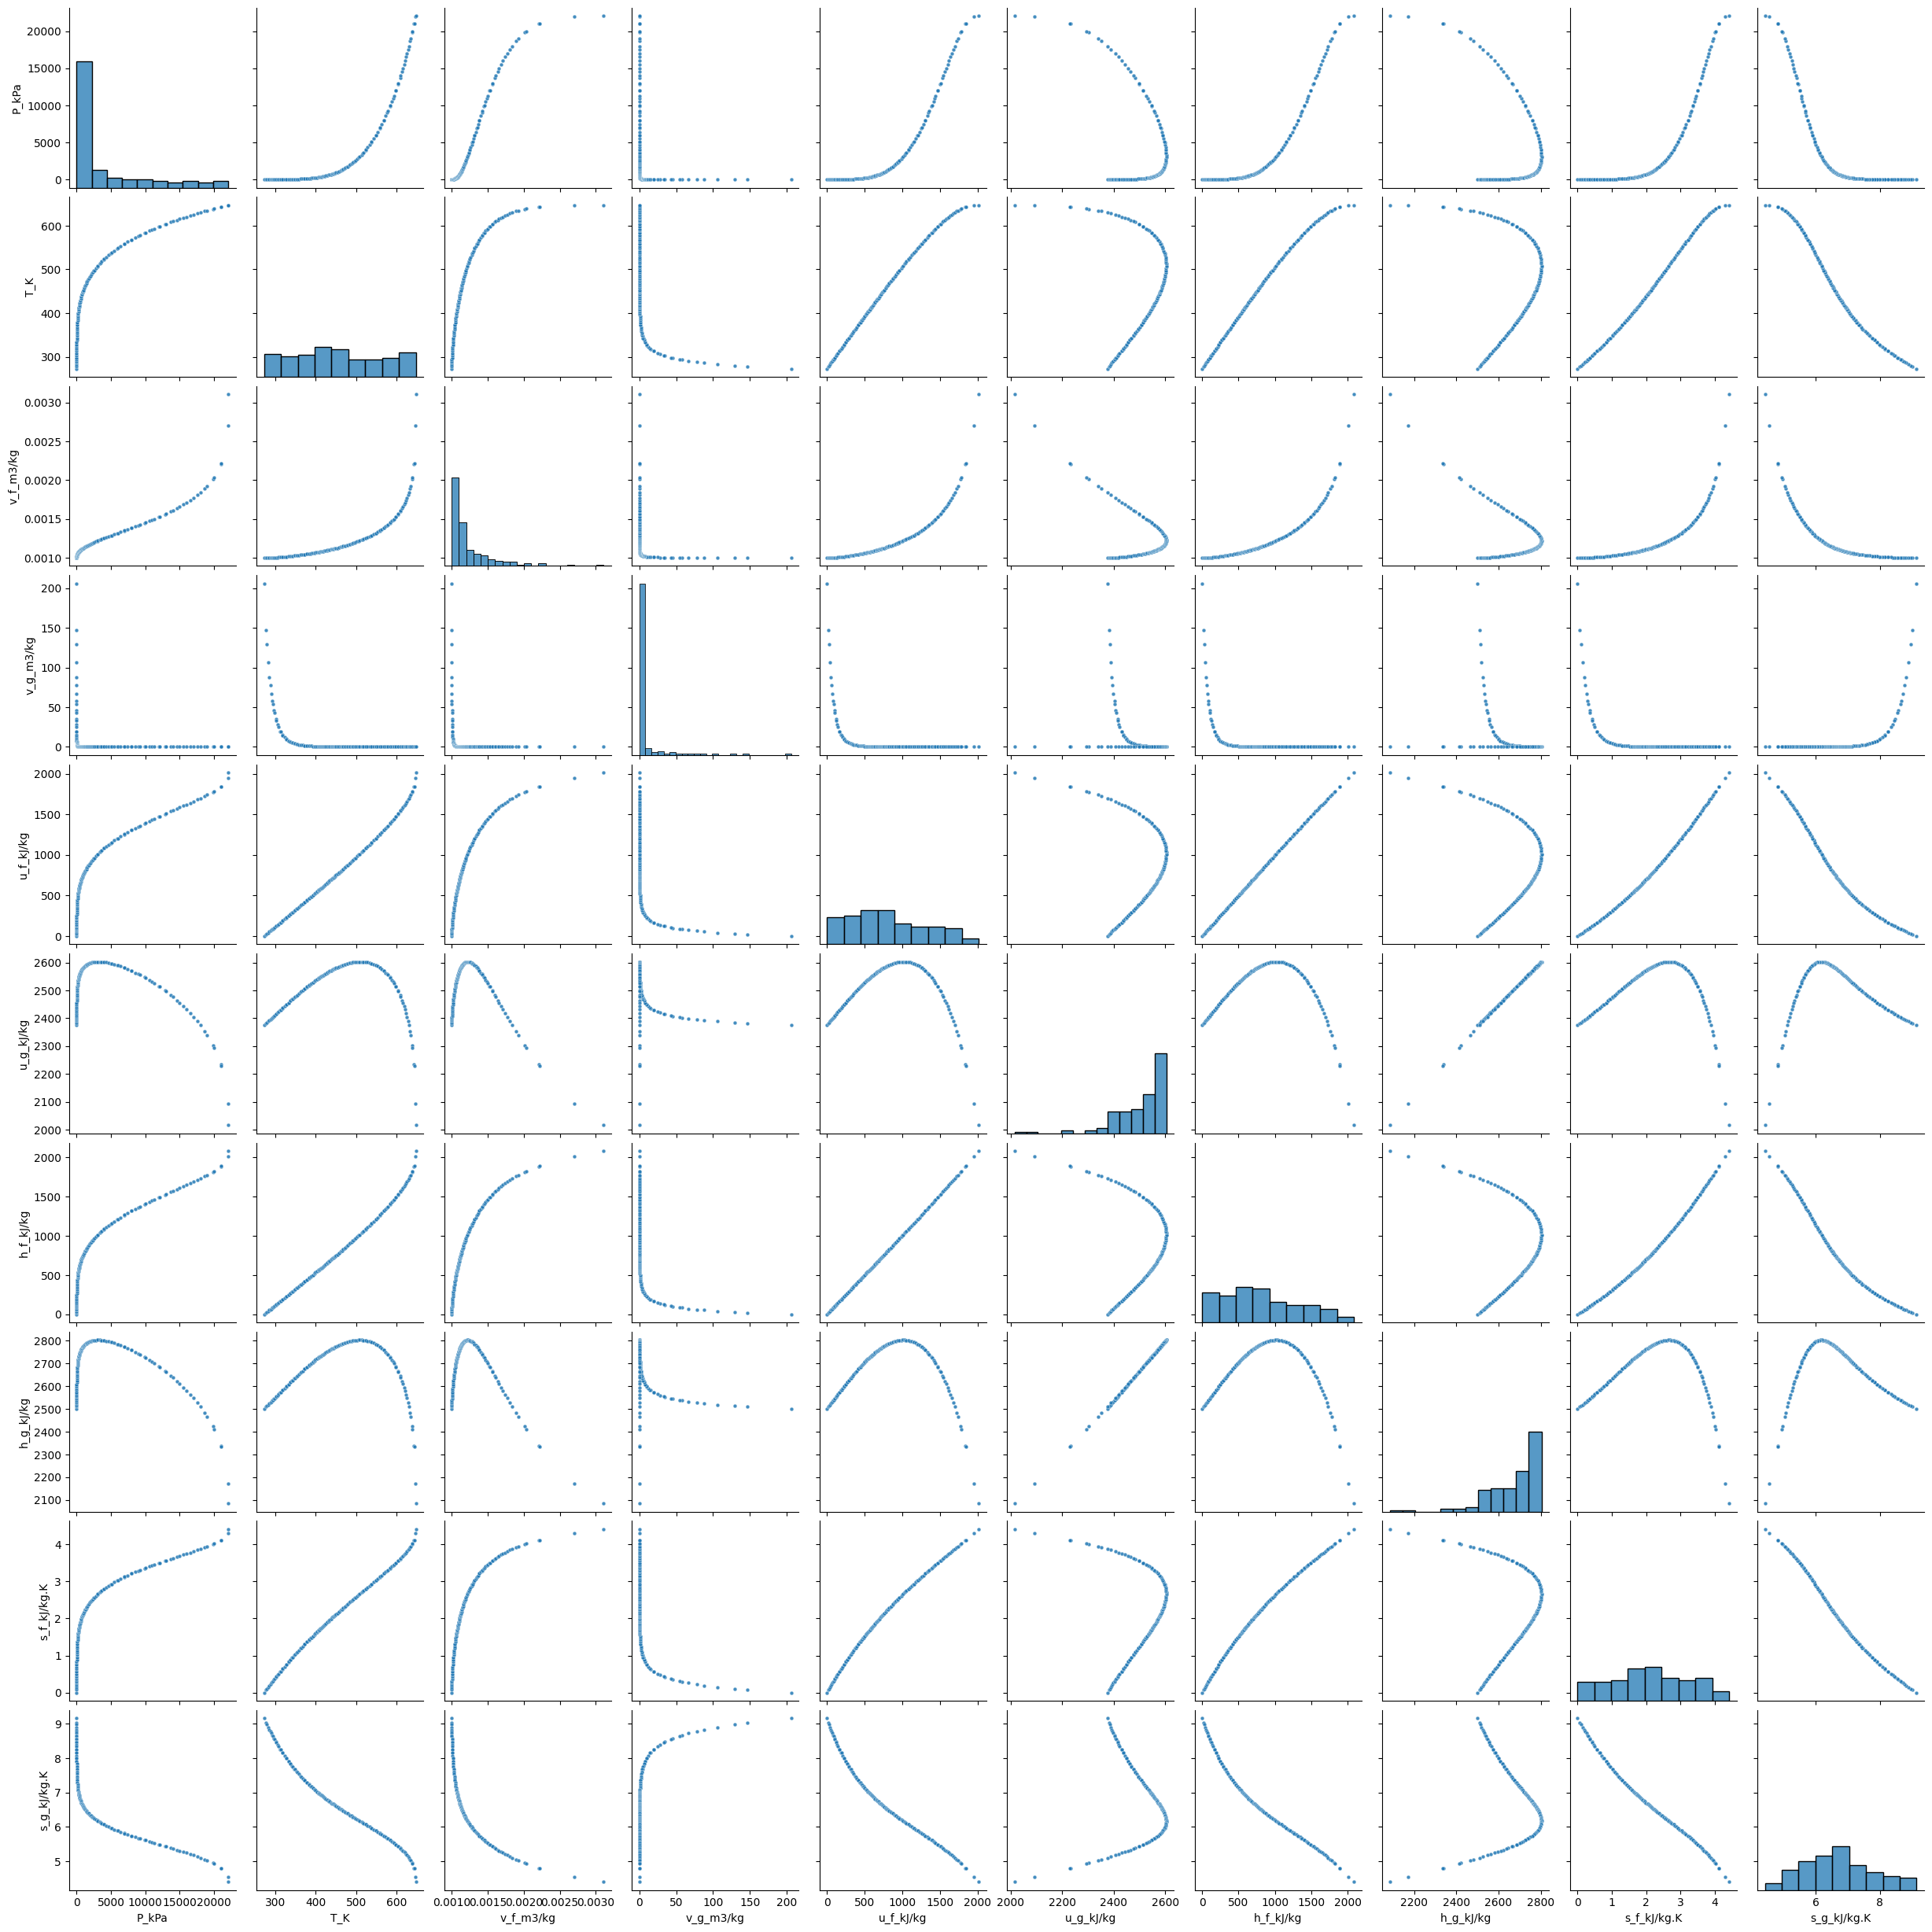

In [72]:
# df_H2O_saturado
sns.pairplot(
    data=df_H2O_saturado,
    kind='scatter',
    diag_kws={'alpha':3/4},
    plot_kws={'alpha': 5/6, 's': 12},
)

- ¿Los incrementos de T son constantes o variables; existen “saltos” grandes que afecten interpolación? : 
> los cambios en T son constante, pero algunas variables contra T si tiene brincos pero ya es en condiciones cercanos a condiciones de frontera
- ¿Se cumple vg >> vf para todo el dominio (el vapor específico es mucho mayor que el líquido)? :
> Tienen una relación $\frac{1}{x}$, es decir para valores pequeños de $v_f$ tenemos $v_g$ grande y viceversa
- ¿Se cumple ug > uf, hg > hf, sg > sf en todo el dominio? :
> No, siempre existe algún punto en el que los puntos de dispersión esta por debajo de la recta $y=x$
- ¿Hay valores negativos en u, h o s donde no deberían aparecer según la convención usada? :
> no se registraron valores negativos
- ¿hf, uf, sf crecen en general con T en líquido saturado (sin “dientes” o retrocesos grandes)? :
> Si , energía interna, entalpía y entropía en estado líquido aumenta con el aumento de T
- ¿hg, ug, sg cambian de forma suave con T; existen inversiones abruptas por errores de digitación? :
> si, se observa forma suave en sus gráficos de saturación y a medida que aumenta la temperatura, estos valores decaen
- ¿vf crece suavemente con T y no presenta caídas abruptas; vg decrece con T (en saturación) de forma razonable y suave? :
> si, en ambos casos se presenta una subida y bajada respectivamente sin cambios abruptos y sin ruido de datos
- ¿Existen oscilaciones locales (sube-baja-sube) incompatibles con tablas publicadas típicas? :
> no se evidencia movimientos erraticos en las gráficas
- ¿Existen outliers puntuales (un “9” de más, signo invertido, o desplazamiento decimal) detectables por saltos entre filas consecutivas :
> No, los datos fueron coherentemente registrados

### Para estado de sobrecalentado

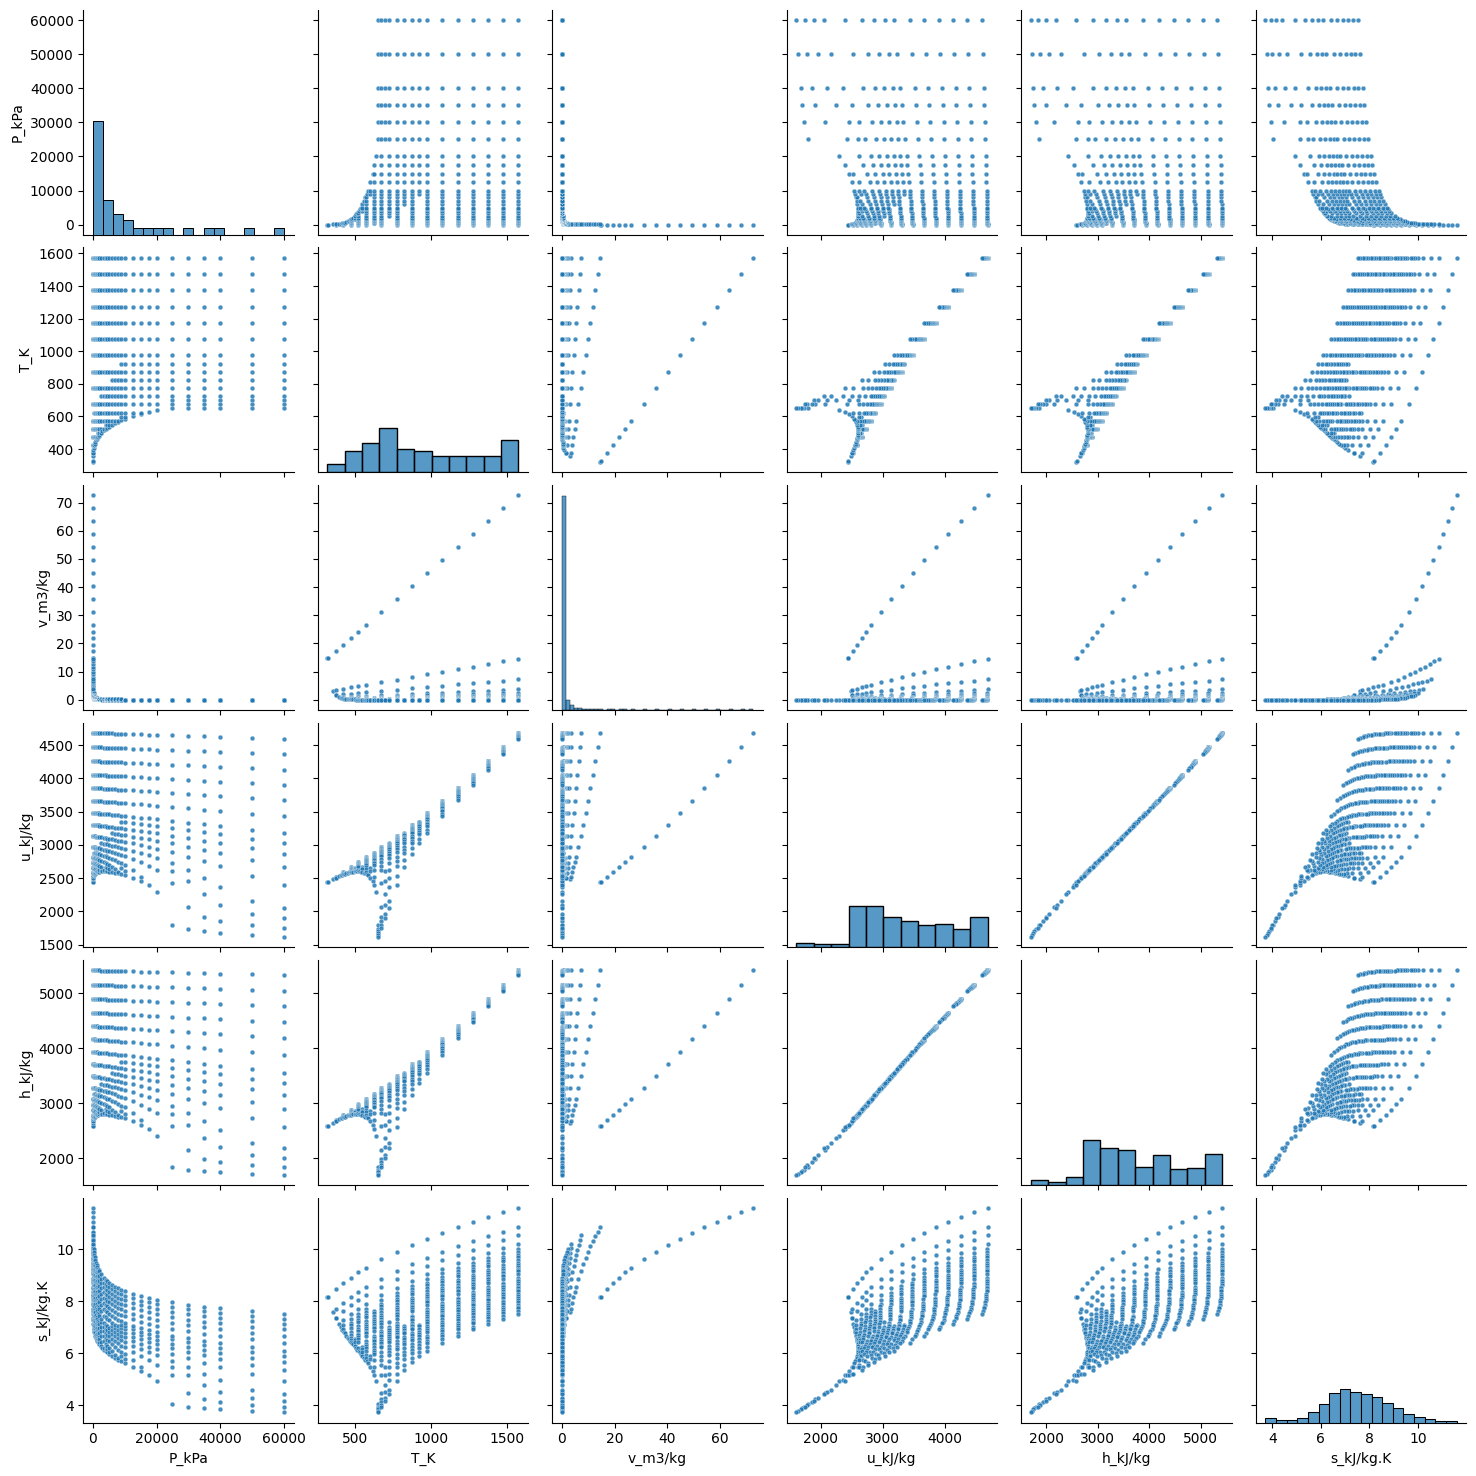

In [73]:
# df_vapsobrecalentado_cleaned
sns.pairplot(
    data=df_vapsobrecalentado_cleaned,
    kind='scatter',
    diag_kws={'alpha':3/4},
    plot_kws={'alpha': 5/6, 's': 12},
)

Es claro que por la gráfica anterior, no es facilmente interpretable la relación entre variables, procedemos a realizar normalización para que cada conlumna tengan la misma escala entre sí. Los principales tipos de normalización / escalado de datos usados en estadística, ciencia de datos y machine learning son los siguientes.

## Normalización Z-score (estandarización)

$$
z = \frac{x − \nu}{\sigma}
$$

$$
\nu : media \newline
\sigma : desviación\:estándar
$$

Propiedades:

- Media 0, varianza 1
- No acota el rango
- Sensible a outliers

Uso típico: Regresión lineal, regresión logística, SVM (support vector machine), PCA (principal component analysis), redes neuronales.

## Normalización Min–Max

$$
x^\prime = \frac{x − x_{\text{min}}}{(x_{\text{max}} − x_{\text{min}})}
$$
Rango típico: [0, 1] (o [a, b] si se reescala)

Propiedades:
- Preserva relaciones relativas
- Muy sensible a outliers
- Acota el rango

Uso típico: Redes neuronales, algoritmos basados en distancia (k-NN, k-means).

## Escalado Max-Abs

$$
x^\prime = \frac{x}{\max(\lvert x \rvert)}
$$

Propiedades:
- Rango [−1, 1]
- No centra los datos
- Mantiene ceros exactos

Uso típico: Datos dispersos (sparse matrices), texto, conteos.

### Normalización por norma (Vector normalization)

$$
x^\prime = \frac{x}{\lvert \lvert x \rvert \rvert_p}
$$

Casos comunes:
- Norma L1: ||x||₁ = Σ|xᵢ|
- Norma L2: ||x||₂ = √(Σxᵢ²)

Propiedades:
- Cada muestra tiene norma 1
- No cambia dirección, solo magnitud

Uso típico: Procesamiento de texto (TF-IDF), similitud coseno, clustering direccional.

## Robust Scaling (escalado robusto)

$$
x^\prime = \frac{x − mediana}{IQR} 
$$

$$
IQR = Q3 − Q1
$$

Propiedades:
- Poco sensible a outliers
- No asume distribución normal

Uso típico: Datos con colas largas, valores extremos frecuentes.

## Transformación logarítmica
$$
x^\prime = log(x + c)
$$
$$
c > 0
$$


Propiedades:
- Reduce asimetría
- Comprime grandes valores
- No lineal

Uso típico: Datos económicos, concentraciones, variables con crecimiento exponencial.

## Power Transform (Box–Cox, Yeo–Johnson)
$$
Box–Cox (x > 0): \newline
x^\prime = \frac{x^\lambda − 1}{\lambda} 
$$

Yeo–Johnson (admite x ≤ 0)

Propiedades:
- Aproxima distribución normal
- Reduce skewness
- Parámetro λ óptimo

Uso típico: Modelos lineales que asumen normalidad.

### Aplicamos z-score a todas las columnas

In [74]:
scaler = StandardScaler()

df_vapsobrecalentado_zscore = pd.DataFrame(
    scaler.fit_transform(df_vapsobrecalentado_cleaned),
    columns=df_vapsobrecalentado_cleaned.columns,
    index=df_vapsobrecalentado_cleaned.index
)
df_vapsobrecalentado_zscore.rename(columns=name_col_map_sat, inplace=True)


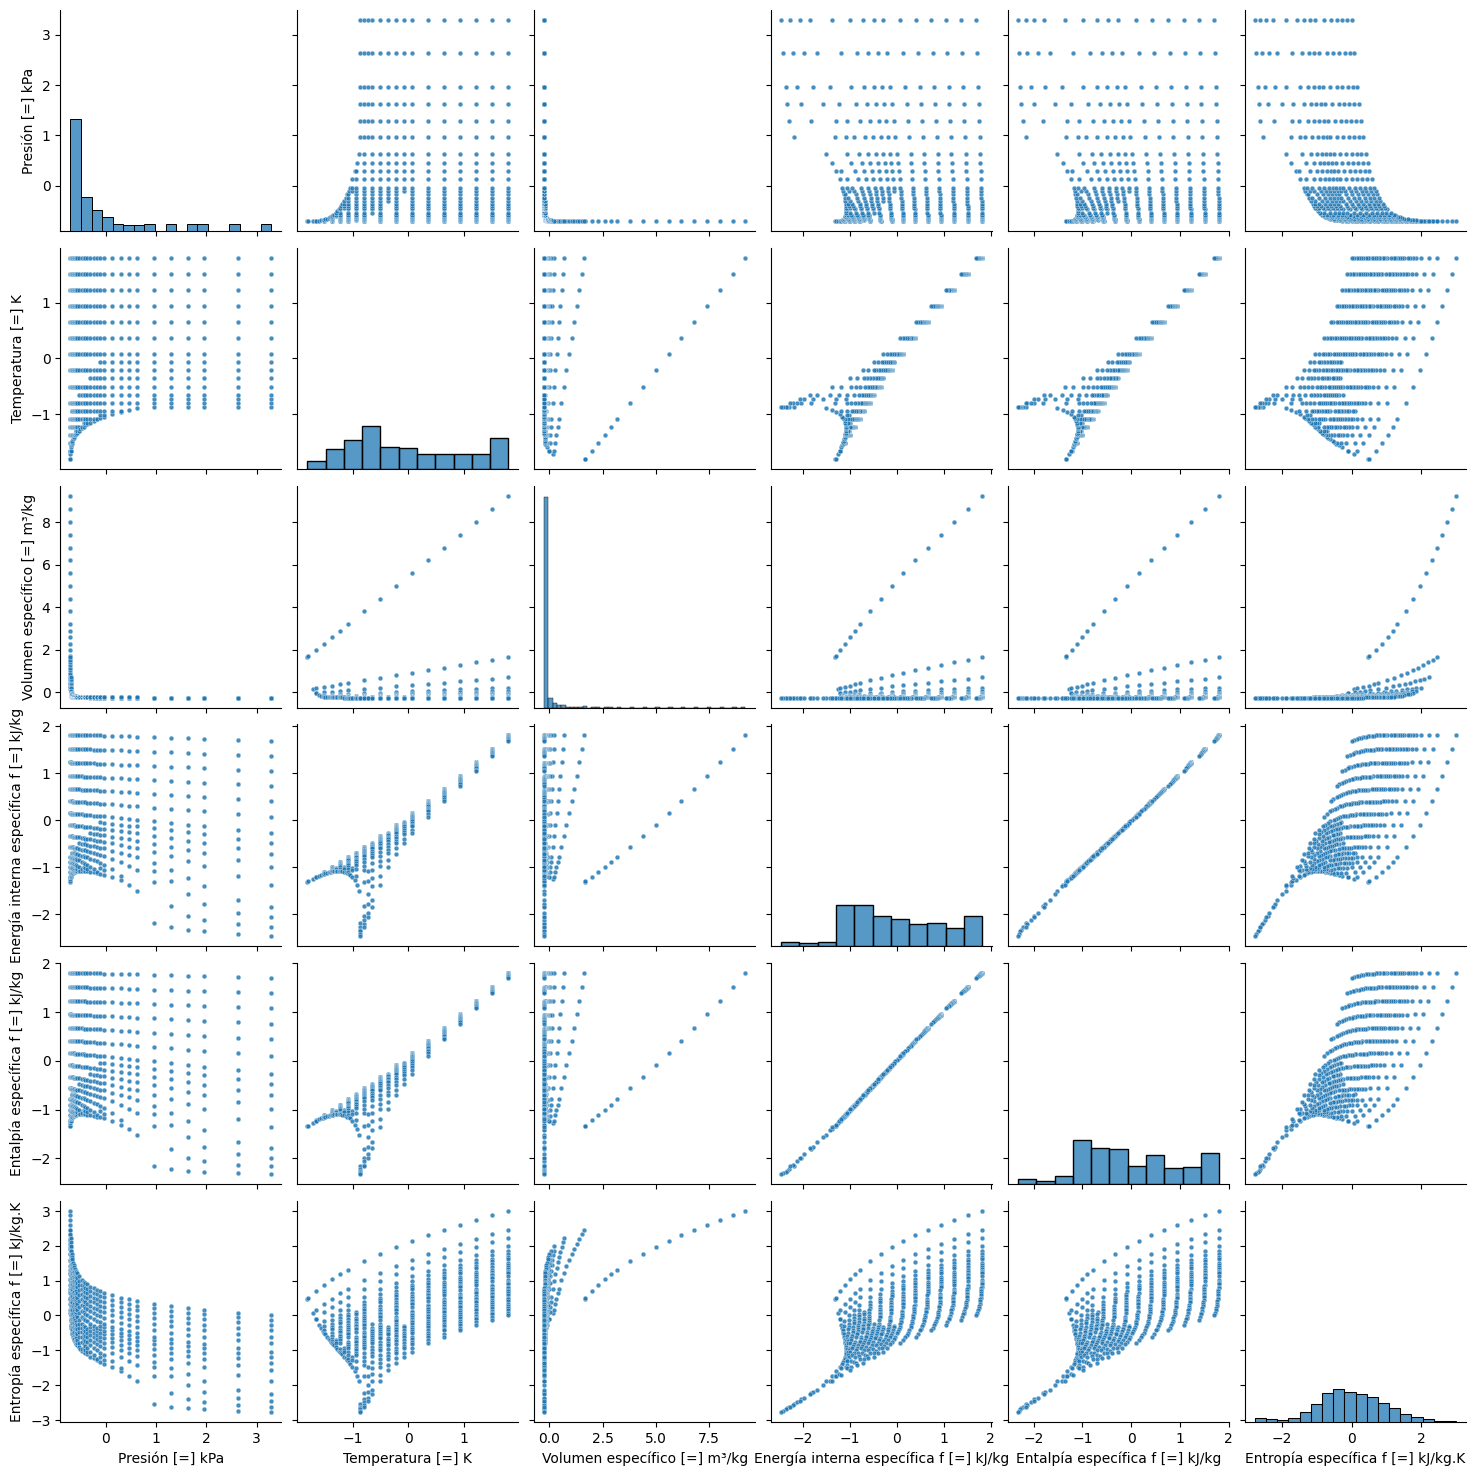

In [75]:
# Realizamos nuevamente la grafica 1vs1 entre todas las variables
sns.pairplot(
    data=df_vapsobrecalentado_zscore,
    kind='scatter',
    diag_kws={'alpha': 3/4},
    plot_kws={'alpha': 5/6, 's': 12},
)

#### Análisis gráfico 3D

In [76]:
df = df_vapsobrecalentado_zscore.copy()

'''
name_col_map_sat = {
    "Presión [=] kPa",
    "Temperatura [=] K",
    "Volumen específico [=] m³/kg",
    "Energía interna específica f [=] kJ/kg",
    "Entalpía específica f [=] kJ/kg",
    "Entropía específica f [=] kJ/kg.K",
}
'''

fig = px.scatter_3d(
    df,
    x="Presión [=] kPa",
    y="Temperatura [=] K",              
    z="Entalpía específica f [=] kJ/kg",
    color="Entalpía específica f [=] kJ/kg",            
    hover_data=["Volumen específico [=] m³/kg", "Energía interna específica f [=] kJ/kg", "Entropía específica f [=] kJ/kg.K"],
)
fig.update_traces(marker=dict(size=3))

r = [
    df[["Presión [=] kPa", "Temperatura [=] K", "Entalpía específica f [=] kJ/kg"]].min().min(),
    df[["Presión [=] kPa", "Temperatura [=] K", "Entalpía específica f [=] kJ/kg"]].max().max(),
]

fig.update_layout(
    scene=dict(
        aspectmode="manual",
        aspectratio=dict(x=1, y=1, z=1),
        xaxis=dict(range=r),
        yaxis=dict(range=r),
        zaxis=dict(range=r),
    ),
    width=1000,
    height=600,
)
fig.show()

#### Analisis Pv = RT

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


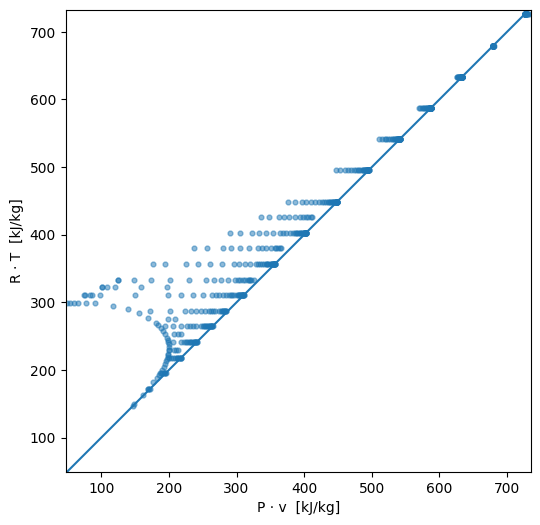

In [77]:
R = 0.4615  # kJ/(kg·K), vapor de agua
df_Pv_RT = pd.DataFrame({
    "Pv_kJkg": df_vapsobrecalentado_cleaned["P_kPa"] * df_vapsobrecalentado_cleaned["v_m3/kg"],
    "RT_kJkg": R * df_vapsobrecalentado_cleaned["T_K"],
})

x = df_Pv_RT["Pv_kJkg"]
y = df_Pv_RT["RT_kJkg"]

lims = [
    min(x.min(), y.min()),
    max(x.max(), y.max())
]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=12, alpha=0.5)
plt.plot(lims, lims)  # x = y
plt.xlabel("P · v  [kJ/kg]")
plt.ylabel("R · T  [kJ/kg]")
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)
plt.show()


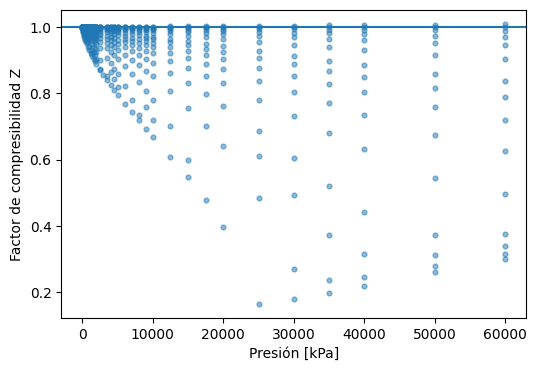

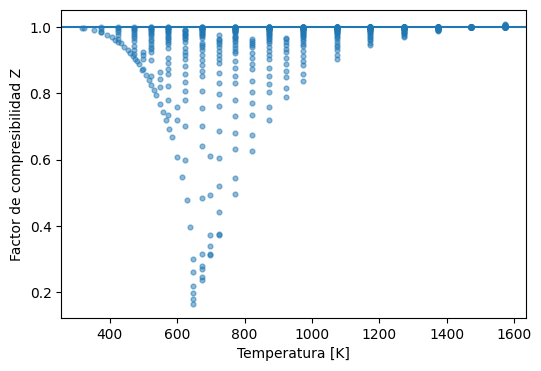

In [78]:
df_Pv_RT["Z"] = df_Pv_RT["Pv_kJkg"] / df_Pv_RT["RT_kJkg"]

plt.figure(figsize=(6, 4))
plt.scatter(df_vapsobrecalentado_cleaned["P_kPa"], df_Pv_RT["Z"], s=12, alpha=0.5)
plt.axhline(1)  # gas ideal
plt.xlabel("Presión [kPa]")
plt.ylabel("Factor de compresibilidad Z")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df_vapsobrecalentado_cleaned["T_K"], df_Pv_RT["Z"], s=12, alpha=0.5)
plt.axhline(1)  # gas ideal
plt.xlabel("Temperatura [K]")
plt.ylabel("Factor de compresibilidad Z")
plt.show()

# Comparación con factor de compresibilidad :

Se compara la gráfica anterior con la gráfica de Nelson-Obert. Referencia: Çengel Y. A. y M. A. Boles, Thermodynamics 8th ed.

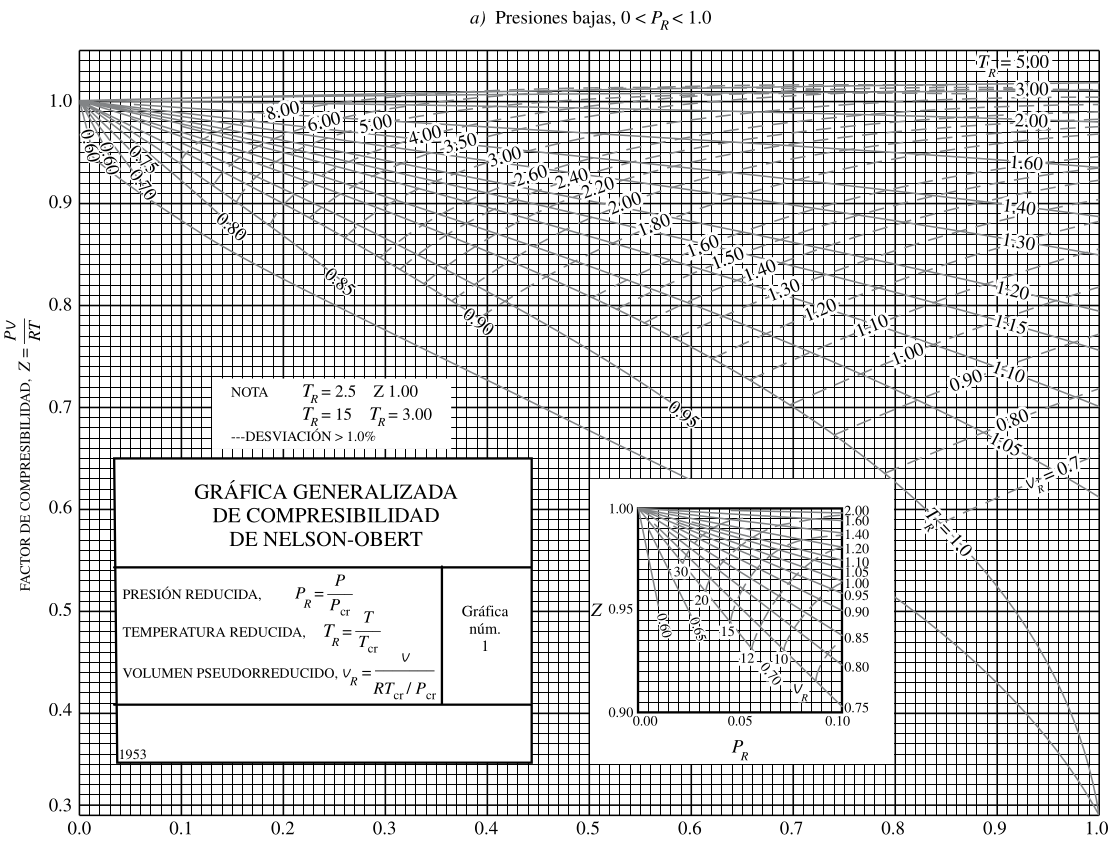

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


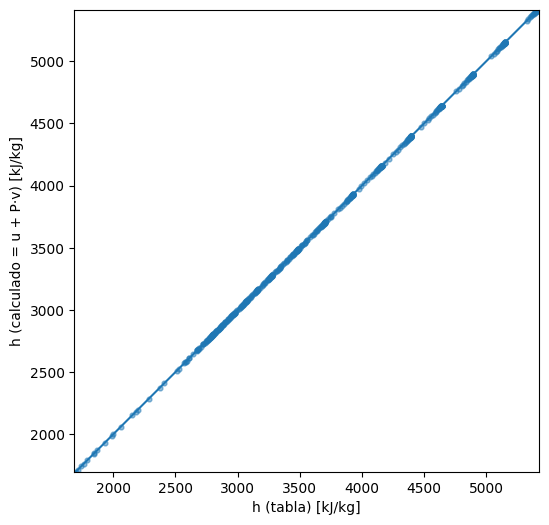

In [79]:
'''
"P_kPa"
"T_K"
"v_m3/kg"
"u_kJ/kg"
"h_kJ/kg"
"s_kJ/kg.K"
'''

df_h_u = pd.DataFrame({
    "P": df_vapsobrecalentado_cleaned["P_kPa"],
    "v": df_vapsobrecalentado_cleaned["v_m3/kg"],
    "u": df_vapsobrecalentado_cleaned["u_kJ/kg"],
    "h_calculado": df_vapsobrecalentado_cleaned["u_kJ/kg"] + (df_vapsobrecalentado_cleaned["P_kPa"] * df_vapsobrecalentado_cleaned["v_m3/kg"]),
    "h_tabla": df_vapsobrecalentado_cleaned["h_kJ/kg"],
})

x = df_h_u["h_tabla"]
y = df_h_u["h_calculado"]

lims = [
    min(x.min(), y.min()),
    max(x.max(), y.max())
]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=12, alpha=0.5)
plt.plot(lims, lims)  # h_calculado = h_tabla
plt.xlabel("h (tabla) [kJ/kg]")
plt.ylabel("h (calculado = u + P·v) [kJ/kg]")
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)
plt.show()

# Conclusiones de los análisis para vapor sobrecalentado : 

- Para T vs P, se puede ver que hay una curva para valores pequeños de Temperatura una asintota parabólica, corresponde a estado de vapor saturado.
- h vs u tiene un comportamiento lineal, obedeciendo la relacion de de $h = u + pv$.
- s vs P, a medida que aumenta la presión, la entropía disminuye.
- s vs T, la entropía sube con la temperatura, para valores bajos se ve claramente un limite curveado, esto hace referencia a comportamiendo de vapor saturado.
- El comportamiento P vs v es lógico, ya que estas dos variables tienen una relación inversamente proporcional ($ P = \frac{1}{v} $).
- Para valores altos de temperatura, la entalpía ya se comporta bajo un modelo lineal ( por esto, para gases por encima de las condiciones críticas sea asume una relación casi lineal para T vs h).
- Para valores altos te presión se puede ver claramente que la entalpía ya tine un comportamiento constante.
- Para $T > 600 K$, se observa que ya tiene tendencia a una relación lineal con $Pv$
- Para presiones bajas, se observa que el factor de compresibilidad se acerca a 1, indicando que tiene comportamientos similares a la de un gas ideal.
- Para temperaturas altas, se observa que el factor de compresibilidad se acerca a 1, indicando que tiene comportamientos similares a la de un gas ideal, pero de 600K para atras, no es recomendable asumir condiciones ideales ya que estos valores se aproximan a estado de vapor saturado.
- Se confirmo efectivamente que $h = u + Pv$